# Open Source RAG - Leveraging Hugging Face Endpoints through LangChain

In the following notebook we will dive into the world of Open Source models hosted on Hugging Face's [inference endpoints](https://ui.endpoints.huggingface.co/).

The notebook will be broken into the following parts:

- 🤝 Breakout Room #2:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating LangChain components powered by the endpoints
  4. Creating a simple RAG pipeline with [LangChain v0.2.0](https://blog.langchain.dev/langchain-v02-leap-to-stability/)

## Task 1: Install required libraries

Now we've got to get our required libraries!

We'll start with our `langchain` and `huggingface` dependencies.



In [1]:
# !pip install -qU langchain-huggingface langchain-community faiss-cpu

## Task 2: Set Environment Variables

We'll need to set our `HF_TOKEN` so that we can send requests to our protected API endpoint.

We'll also set-up our OpenAI API key, which we'll leverage later.



In [2]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

## Task 3: Creating LangChain components powered by the endpoints

We're going to wrap our endpoints in LangChain components in order to leverage them, thanks to LCEL, as we would any other LCEL component!

### HuggingFaceEndpoint for LLM

We can use the `HuggingFaceEndpoint` found [here](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/llms/huggingface_endpoint.py) to power our chain - let's look at how we would implement it.

In [3]:
YOUR_LLM_ENDPOINT_URL = "https://pxix4hjjblomy3cx.us-east-1.aws.endpoints.huggingface.cloud"

In [4]:
from langchain_community.llms import HuggingFaceEndpoint

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    max_new_tokens=512,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
    huggingfacehub_api_token=os.environ["HF_TOKEN"]
)

/home/nisargvp/anaconda3/envs/axo/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEndpoint`.
  warn_deprecated(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/nisargvp/.cache/huggingface/token
Login successful


Now we can use our endpoint like we would any other LLM!

In [5]:
hf_llm.invoke("Hello, how are you?")

" I hope you're having a great day! I just wanted to say that I'm really enjoying your blog and the content you're sharing. It's so inspiring and helpful. I've been following your blog for a while now, and I have to say that it's one of my favorite blogs to read. You have a way of making complex topics seem simple and easy to understand, which is really impressive. Keep up the great work! I'm looking forward to reading more of your posts in the future.\nThank you so much for your kind words! I'm thrilled to hear that you're enjoying my blog and finding it helpful. That means a lot to me, and I'm glad I can make a positive impact on your day. I strive to make my content accessible and easy to understand, so it's great to know that I'm achieving that goal. If you have any specific topics or questions you'd like me to cover in future posts, feel free to let me know! I'm always happy to hear from my readers and tailor my content to their interests. Thanks again for your support, and I look

Now we can add a RAG-style prompt using Llama 3 Instruct's prompt templating!

In [6]:
from langchain_core.prompts import PromptTemplate

RAG_PROMPT_TEMPLATE = """\
<|start_header_id|>system<|end_header_id|>
You are a helpful assistant. You answer user questions based on provided context. If you can't answer the question with the provided context, say you don't know.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
User Query:
{query}

Context:
{context}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(RAG_PROMPT_TEMPLATE)

Let's create a simple LCEL chain using our prompt template Runnable and our LLM Runnable.

In [7]:
rag_chain = rag_prompt | hf_llm

In [8]:
rag_chain.invoke({"query" : "Who old is Carl?", "context" : "Carl is a sweet dude, he's 40."})

'According to the context, Carl is 40 years old.'

### HuggingFaceInferenceAPIEmbeddings

Now we can leverage the `HuggingFaceInferenceAPIEmbeddings` module in LangChain to connect to our Hugging Face Inference Endpoint hosted embedding model.

In [9]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings

YOUR_EMBED_MODEL_URL = "https://jq20znepdxwhubpi.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
)

Let's build a simple cosine-similarity function to verify our endpoint is working as expected.

In [10]:
import numpy as np
from numpy.linalg import norm

def cosine_similarity(phrase_1, phrase_2):
  vec_1 = hf_embeddings.embed_documents([phrase_1])[0]
  vec2_2 = hf_embeddings.embed_documents([phrase_2])[0]
  return np.dot(vec_1, vec2_2) / (norm(vec_1) * norm(vec2_2))

Let's try a few examples below!

In [11]:
cosine_similarity("I love my fluffy dog!", "I adore this furry puppy!")

0.8903063446222079

In [16]:
cosine_similarity("I love my fluffy dog!", "Eating pizza is the worst! Yuck!")

0.743020791930313

## Task 4: Preparing Data!

We'll start by loading some data from GitHub (Paul Graham's Essays) and then move to chunking them into manageable pieces!

First - let's grab the repository where the files live.

In [17]:
!git clone https://github.com/dbredvick/paul-graham-to-kindle.git

Cloning into 'paul-graham-to-kindle'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 36 (delta 3), reused 31 (delta 1), pack-reused 0
Unpacking objects: 100% (36/36), 2.35 MiB | 1.35 MiB/s, done.


Next - we can load them using LangChain!

In [18]:
from langchain_community.document_loaders import TextLoader

document_loader = TextLoader("./paul-graham-to-kindle/paul_graham_essays.txt")
documents = document_loader.load()

Now, let's split them into 1000 character pieces.

In [19]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=30)
split_documents = text_splitter.split_documents(documents)
len(split_documents)

4265

Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

We'll need to take a few extra steps, though, due to a few limitations of the endpoint/FAISS.

We'll start by embeddings our documents in batches of `32`.

> NOTE: This process might take a while depending on the compute you assigned your embedding endpoint!

In [20]:
from langchain_community.vectorstores import FAISS

for i in range(0, len(split_documents), 32):
  if i == 0:
    vectorstore = FAISS.from_documents(split_documents[i:i+32], hf_embeddings)
    continue
  vectorstore.add_documents(split_documents[i:i+32])

Next, we set up FAISS as a retriever.

In [21]:
hf_retriever = vectorstore.as_retriever()

## Task 5: Simple LCEL RAG Chain

Now we can set up our LCEL RAG chain!

> NOTE: We're not returning context for this example, and only returning the text output from the LLM.

In [22]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

lcel_rag_chain = {"context": itemgetter("query") | hf_retriever, "query": itemgetter("query")}| rag_prompt | hf_llm

In [23]:
lcel_rag_chain.invoke({"query" : "What is the best part of Silicon Valley?"})

'Based on the provided context, it seems that Paul Graham, the author, is discussing the shortcomings of Silicon Valley and suggesting ways to improve it. He mentions that the best part of Silicon Valley is not the physical location itself, but rather the people who inhabit it.\n\nHowever, he also criticizes the area, stating that it is "not so bad" but has a lot of room for improvement. He specifically mentions the strip development and the demoralizing commute times as areas that need improvement.\n\nIt\'s not clear what the "best part" of Silicon Valley is, as the author is more focused on its weaknesses and how to improve it. If I had to guess, I would say that the best part might be the presence of top universities, such as Stanford, which attract talented individuals and create a hub for innovation. However, this is not explicitly stated in the provided context.'

### LLM Endpoint Usage

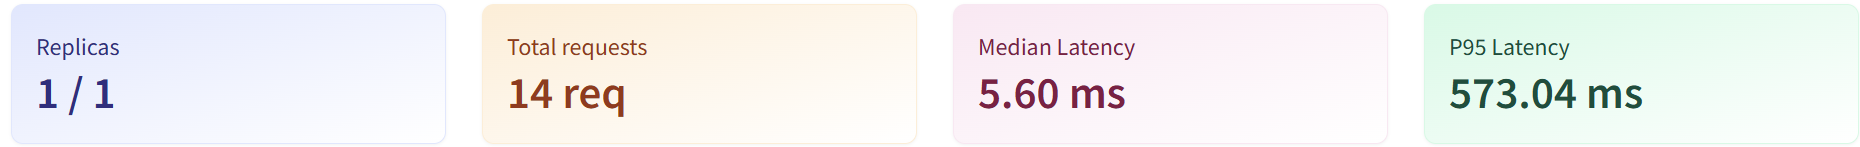

### Embedding Endpoint Usage

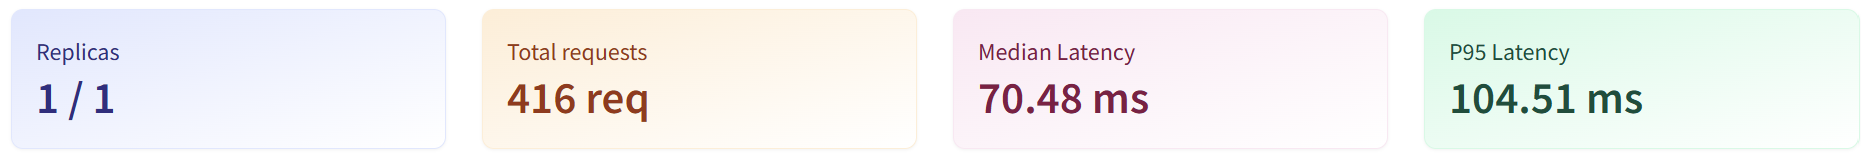